In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# RNN for Japanese Phonology with Phoneme Embeddings using Japanese and English data

This notebook contains the code which trains an RNN on the English Switchboard Corpus and on the Corpus of Spontaneous Japanese to learn phonological patterns in Japanese. The training data has 30% of its data of Japanese and 70% of English. 
The RNN is trained using Keras. 

Additionally, the embeddings produced in this model are analyzed using principal component analysis, to determine what phonetic or articulatory features are picked up by the neural network.

**Before running anything:**

Make sure to set this notebook to run on a GPU. This drastically reduces the time needed to train the network. To do this, go to Edit-->Notebook Settings, and under Hardware Accelerator, select GPU.

This project is largely based off of the work of Mirea and Bicknell (2019):

https://www.aclweb.org/anthology/P19-1155/




## 1. Install the necessary dependencies

The RNN is implemented in Keras, and some functions are used from sklearn to perform PCA, and split the corpus in to train, valid and test data. Furthermore, the NN performs random calculations each time it is run. In order to solve that, the "seed" fuctions at the end of the code are necessary. The parameters of the variables could be any numbers. See https://machinelearningmastery.com/reproducible-results-neural-networks-keras for more details.

In [ ]:
# the required dependencies

%tensorflow_version 1.x

from nltk import FreqDist

from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import os
import numpy as np

import matplotlib.pyplot as plt
import re
from random import sample 

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


TensorFlow 1.x selected.


Using TensorFlow backend.


## 2. Connect this notebook to Google Drive to read in the SwitchBoard corpus

This code needs to be executed each time the notebook is restarted.

Running this cell will print a URL. Go to this URL and log into your account. Afterwards, you will be given a code. Enter this code into the textbox below, and your drive will be accessible by this notebook.

If your drive is mounted successfully, you should see "Mounted at /content/drive" below.

In [ ]:
# this code allows this notebook to access the google drive folder to read in the corpus
# run this cell, and go to the link which is printed.
# the link will tell you to sign in, and at the end will give you a code
# copy this code and past it in the textbox that appears below.
# this process needs to be repeated each time this notebook is restarted

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The file  'clean_words.csv' should be listed when this code is executed.

If not, change the variable 'folder' to match the location of this notebook, and make sure the Switch Board files are in the same directory.

In [ ]:
#finding the directory with the files
!cd drive
!ls drive/MyDrive/RNNs/segments/BilingualRNN

BilingualEmbedding10eng90jp.ipynb  csj_proc_1.csv  nonsense_geminates.csv
BilingualEmbedding50eng50jp.ipynb  csj_proc_2.csv  nonsense_nasals.csv
csj_proc_0.csv			   csj_proc_3.csv  output2.csv


In [ ]:
folder = '/content/drive/MyDrive/RNNs/segments/BilingualRNN/'

print(os.listdir(folder))

['nonsense_nasals.csv', 'nonsense_geminates.csv', 'output2.csv', 'csj_proc_0.csv', 'csj_proc_3.csv', 'csj_proc_2.csv', 'csj_proc_1.csv', 'BilingualEmbedding50eng50jp.ipynb', 'BilingualEmbedding10eng90jp.ipynb']


## 3. Read clean data from the corpora

The files clean_data_*.csv contain data extracted from the CSJ.
The file outpu2.csv contains data from the Swicthboard corpus. 
 This code extracts the phonetic transcription of the actual pronounced form of each word in the corpus.

Our phonetic transcription is listed in the dictionary below, which converts each Latin letter to the phoneme it represents in IPA.



In [ ]:

ipas = { 
	
	#symbols shared by English and Japanese
	#consonants 
	"p" : "p" ,
	"k" : "k" ,
	"g" : "g" ,
	"t" : "t" ,
	"d" : "d",
	"b" : "b",

	"m" : "m", 
	"n" : "n", 
 	"G" : "ŋ",

	 "S":	"ɕ",
	 "Z":	"ʑ",
	 "Z" : "ʒ", 
	 "h" : "h",
	 "z" : "z",
	 "s" : "s" ,
	 "f" : "f" ,
	 	"r" : "ɾ",


	 #vowels 
	"i" : "i:",
	"e" : "e",
	
	"w" : "w" ,
	"y" : "j" ,

	#Symbols exclusive to Japanese
	"a" : "a" ,
	"c":	"ç",
	"f":	"ɸ",
	"M":	"ɲ",
	"N":	"ɴ",

	#Symbols exclusive to English 
	"I" : "ɪ", 
	"3" : "eɪ",
	"A" : "æ",
	"O" : "ɒ", 
	"U" : "u:", 
	"4" : "ə", 
	"0" : "ʌ",
	"(" : "u:", 
	"u" : "ʊ", 
	"o" : "ɔː",
	"Y" : "ai", 
	"8" : "ɔi", 
	"5" : "au", 
	"6" : "oʊ", 
	"I" : "ɪ", 
	"^" : "ɝ",

	"9" : "m̩",
	"2" : "n̩",
	"&" : "ŋ̩",
	"@" : "ɾ̃", 
	



	"H" : "hw",

	"L" : "ɫ",
	"l" : "l", 
	"7" : "l̩",

	"v" : "v" ,
	"F": "θ",
	"D" : "ð", 
	
	
		"R" : "r" ,
	}

print(ipas)

def phon2ipa(char):
  # word is a list of chars

  if char in ipas:
    return ipas[char]
  else:
    return char 
  

{'p': 'p', 'k': 'k', 'g': 'g', 't': 't', 'd': 'd', 'b': 'b', 'm': 'm', 'n': 'n', 'G': 'ŋ', 'S': 'ɕ', 'Z': 'ʒ', 'h': 'h', 'z': 'z', 's': 's', 'f': 'ɸ', 'r': 'ɾ', 'i': 'i:', 'e': 'e', 'w': 'w', 'y': 'j', 'a': 'a', 'c': 'ç', 'M': 'ɲ', 'N': 'ɴ', 'I': 'ɪ', '3': 'eɪ', 'A': 'æ', 'O': 'ɒ', 'U': 'u:', '4': 'ə', '0': 'ʌ', '(': 'u:', 'u': 'ʊ', 'o': 'ɔː', 'Y': 'ai', '8': 'ɔi', '5': 'au', '6': 'oʊ', '^': 'ɝ', '9': 'm̩', '2': 'n̩', '&': 'ŋ̩', '@': 'ɾ̃', 'H': 'hw', 'L': 'ɫ', 'l': 'l', '7': 'l̩', 'v': 'v', 'F': 'θ', 'D': 'ð', 'R': 'r'}


### 3.1. Reading data from the Switchboard Corpus



The words which only contain phonetic symbols are selected as our dataset (second column of the corpus, [1]).


In [ ]:
c0 = folder + 'output2.csv'

word_set_eng = []

for c in [c0]:
  with open(c) as f:
    #next(f)
    for line in f:
      line = line.replace('r', 'R') #changing r to R (retroflex)
      line = line.replace(' ', '') #getting rid of that damn thing 
      line = line.replace('\n', '') #getting rid of that damn thing 
      vals = line.split(',')
      

      # index one contains the actual pronounced form
      word = vals[1]
      

      skip = None

      #for char in word:
        # select words with only phonetic characters (no punctuation, no crying)
       # if char not in ipas.keys():
        # skip = True

      #if skip:
       # continue

    
      word_set_eng.append(vals[1])
      #break

print("{} words were read from the Switch board corpus".format(len(word_set_eng)))
print("The first word is \"{}\"".format(word_set_eng[0]))
print("The last word is \"{}\"".format(word_set_eng[-1]))

30074 words were read from the Switch board corpus
The first word is "O"
The last word is "wIndi"


### 3.2. Reading data from the CSJ



In [ ]:

c0 = folder + 'csj_proc_0.csv'
c1 = folder + 'csj_proc_1.csv'
c2 = folder + 'csj_proc_2.csv'
c3 = folder + 'csj_proc_3.csv'

words_j = []

for c in [c0, c1, c2, c3]:
  with open(c, encoding="UTF-8") as f:
    next(f)
    for line in f:
      vals = line.split(',')

      # index six contains the actual pronounced form
      word = vals[6]

      skip = None

      for char in word:
        # select words with only phonetic characters (no punctuation, no crying)
        if char not in ipas.keys():
         skip = True

      if skip:
        continue

      words_j.append(vals[6])
      #break

print("{} words were read from the CSJ corpus".format(len(words_j)))
print("The first word is \"{}\"".format(words_j[0]))
print("The last word is \"{}\"".format(words_j[-1]))

6033404 words were read from the CSJ corpus
The first word is "mazu"
The last word is "masu"


## 4. Determining word types for Japanese words 

Most words in the corpus (or in any language dataset) contain a small number of tokens which account for a majority of the corpus. See the 20 most common words from the corpus below, and see the amount of the corpus they produce.

To reduce the size of the corpus, each word type will be used in our dataset, rather than each token. However, it may be the case that using word tokens would be more useful for the RNN. This question will be set aside for later research.

Using only word types reduces the size of our dataset to around ~50,000.
This is not done for English data because the corpus is already in types. 

In [ ]:
fd = FreqDist(words_j)

print("word".ljust(10), "count")
print("*"*30)
for word, count in fd.most_common(20):
  print(word.ljust(10), str(count).rjust(5))


word_set_j = list(fd.keys())

print("*"*30)
print()
print("There are {} types in the corpus".format(len(word_set_j)))

word       count
******************************
no         305519
te         252460
ni         234134
to         231304
de         198862
ga         177707
wa         163302
o          160428
ta         136837
desu       124803
yuu        111911
Si         104959
mo         95705
ka         93301
N          91167
masu       89451
na         75560
koto       63118
maSi       53067
nai        45170
******************************

There are 50469 types in the corpus


 ## 5. Combining English and Japanese
Here a bilingual corpus comprised of 50%-50% Japanese/English data is being calculated.

In [ ]:
print(len(word_set_j))
print(len(word_set_eng))

from random import sample 
#reducing the number of Japanese of the corpus to the same number of the English corpsus. 
reducer = round((len(word_set_eng)*2) * 0.3)

word_set_j_reduced = sample(word_set_j,reducer)

word_set = word_set_j_reduced + word_set_eng 

50469
30074


## 6. Create Character Encodings

Neural networks are mathematical functions, so its inputs must be represented as numbers. The code below assings a unique integer to each character in the dataset. Two special tokens are introduced to indicate the end of a word, and to pad the word to a given length (to be explained later).

Two dictionaries are created:
- char2id - converts each Latin-based phoneme to its code
- id2char - converts each code back to its Latin-based phoneme

In [ ]:

char2id = {}
id2char = {}

char2id["PAD"] = 0
char2id["END"] = 1

counter = 2
for c in ipas.keys():
  char2id[c] = counter
  counter += 1

for c in char2id:
  currid = char2id[c]
  id2char[currid] = c

## 7. Convert Each Word Type to its Character Encoding

The code below converts each word type from the corpus into a sequence of character codes, which are stored in a numpy array.

Each character code sequence is padded such that all of the word representations are of the same length. The sequences are long enough such that the longest word plus the end token can be represented in the array.

The sequences are written into the variable word_grid. The first index of word_grid accesses the word sequence, and the second index accesses each character:
  - word_grid[word_ind, char_ind]
  

In [ ]:
max_len = max(len(w) for w in word_set) + 1

word_grid = np.zeros((len(word_set), max_len))

print(word_set)

['kiritaoSi', 'nigia', 'kumiaase', 'katazukero', 'meebutsu', 'kuimoN', 'sokudZu', 'tooha', 'yuimee', 'keigeN', 'buNrii', 'adoribu', 'ikesu', 'eege', 'eberesuto', 'tanomura', 'tokkoo', 'kiwamari', 'hoMiN', 'moosooku', 'gemmee', 'uttae', 'Soto', 'yuniguramutSi', 'goSigoSi', 'bampetsu', 'cikitsuke', 'dZigeGkeN', 'zutsugo', 'harorudo', 'kakiwake', 'ruaa', 'uSinomikoto', 'bendZamiN', 'koGguresu', 'nusumidori', 'hossa', 'bokkowaSi', 'ikikaere', 'suteppusaizu', 'maisoo', 'dZidZitsu', 'tSakatSaka', 'kokoromiru', 'editto', 'namboku', 'todZiSiro', 'keekisutando', 'heebee', 'kizuri', 'pombu', 'okurikomu', 'karappo', 'pooru', 'marakaibo', 'rari', 'deetabekutoru', 'riGkubeesu', 'dokukaree', 'godZai', 'doogo', 'cikiharau', 'rooSoo', 'furikomu', 'hesee', 'entaGguriro', 'iGkuruudo', 'ainte', 'tsurisage', 'haNraN', 'uriage', 'parusuguN', 'dokuri', 'moorisu', 'hasami', 'fuNnyuu', 'suifu', 'aomono', 'sukurooru', 'dZiuN', 'muSitsu', 'yakubarai', 'fitto', 'furoppii', 'muSimono', 'adobanteedZi', 'biku', 'ko

In [ ]:
max_len = max(len(w) for w in word_set) + 1

word_grid = np.zeros((len(word_set), max_len))

for word_i in range(len(word_set)):
  curr_word = word_set[word_i]
  for char_i in range(len(curr_word)):
    curr_char = curr_word[char_i]
    word_grid[word_i, char_i] = char2id[curr_char]
  
  word_grid[word_i, len(curr_word)] = char2id["END"]

print('The longest word in the corpus is {} characters long'.format(max_len))

example_index = 5

print()
print("*** Example word in the corpus ***")
print()
print(word_set[example_index])

print()
print("*** The character codes ***")
print()
for c in word_set[example_index]:
  print(" {:3} --> {}".format(c, char2id[c]))
print(" {:3} --> {}".format("END", char2id["END"]))
print(" {:3} --> {}".format("PAD", char2id["PAD"]))

print()
print("*** The final padded array for \"{}\" ***".format(word_set[example_index]))
print(word_grid[example_index,:])

print()
print("*" * 30)
print("The final dimensions of the word array: {}".format(word_grid.shape))

The longest word in the corpus is 24 characters long

*** Example word in the corpus ***

kuimoN

*** The character codes ***

 k   --> 3
 u   --> 34
 i   --> 18
 m   --> 8
 o   --> 35
 N   --> 25
 END --> 1
 PAD --> 0

*** The final padded array for "kuimoN" ***
[ 3. 34. 18.  8. 35. 25.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]

******************************
The final dimensions of the word array: (48118, 24)


## 8. Create an object which creates one-hot encodings

We chose to represent each character in the neural network with a one-hot vector. A one-hot vector is a vector which contains a single 1, and all of its other values are 0. For our purposes, the index of the 1 in the one-hot vector corresponds to the character code of the phoneme.

The one-hot vector can be interpretted as a probability distribution, where each value represents the likelihood of each character. The input to the neural network will represent the probability of each character with 100%, and the output of the neural network will reflect the uncertainty of the network for each character.

In [ ]:
print("*** Example character:\n    \"{}\"".format('e'))
print("*** Code for \"{}\":\n    {}".format('e', char2id['e']))
print("*** One-hot vector for \"{}\":\n    {}"\
      .format('e', to_categorical(char2id['e'], num_classes=len(char2id))))

*** Example character:
    "e"
*** Code for "e":
    19
*** One-hot vector for "e":
    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


Note that the one-hot vectors are much larger than the characters or the character codes. If the entire dataset were converted to one-hot vectors, the dataset would be too large to handle:

In [ ]:
print("Values needed for one-hot encodings for entire dataset: {}"
  .format(len(word_set) * max_len * len(char2id)))

Values needed for one-hot encodings for entire dataset: 61206096



To alleviate this problem, an object can be created which generates the one-hot vectors only for the characters needed, instead of creating one-hot vectors for the entire training set.

In [ ]:
class BatchGenerator:
  def __init__(self, words, num_steps, batch_size, num_phonemes):
    # an array of sentences, represented as words with ordinal codes
    self.words = words
    self.num_steps = num_steps
    self.batch_size = batch_size
    self.num_phonemes = num_phonemes

    self.index = 0

    self.end_code = char2id["END"]

  def generate(self):
    x = np.zeros((self.batch_size, self.num_steps))
    y = np.zeros((self.batch_size, self.num_steps, self.num_phonemes))

    while True:
      for i in range(self.batch_size):
        x[i, :] = self.words[self.index]

        # shift the outputs over by one index
        temp_y = np.append(self.words[self.index,1:], self.end_code)

        y[i, :, :] = to_categorical(temp_y, num_classes=self.num_phonemes)

        self.index += 1
        if self.index >= len(self.words):
          self.index = 0
      yield x, y

The code below shows how the BatchGenerator object can be used.

train_gen.generate() returns an iterator which creates each batch of input words, along with its expected output as a one-hot vector.

The number of words used in a particular batch can be modified with the batch_size parameter.

In [ ]:
batch_size = 2 #two words

train_gen = BatchGenerator(word_grid, max_len, batch_size, len(char2id))

for x, y in train_gen.generate():
  print("Inputs:")
  print(x)
  print()
  print("Input shape: {}".format(x.shape))

  print()
  print("Targets:")
  print(y)
  print()
  print("Target shape: {}".format(y.shape))

  # stop the loop because this is just an example
  break
  #3 dimensions: n. of words, charc. index (first, second, third), character ID

Inputs:
[[ 3. 18. 17. 18.  5. 22. 35. 11. 18.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 9. 18.  4. 18. 22.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]]

Input shape: (2, 24)

Targets:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]]

Target shape: (2, 24, 53)


## 9. Set up the neural architecture

This code sets up the neural architecture in Keras.

We chose to implement a two-layered LSTM RNN.

The input to the network is an embedding layer. This layer is a linear transformation which converts a character code to a vector of a given size (embedding_size). As the network trains, the embedding vector for each character will adjust, such that similar characters will develop similar embeddings. These embeddings will be analyzed later in this notebook.

The embeddings are fed into an LSTM layer. LSTM was used by Mirea and Bicknell.

The output of the LSTM layer is fed to a second LSTM layer. (Found to be ideal by Mirea and Bicknell).

The output of the second LSTM layer is provided to a "Dense" (feed-forward) layer. This converts the output of the LSTM to a one-hot vector, which represents the RNNs output.

The code below constructs the network, and prints a summary of the number of adjustable parameters needed for the network. This network contains around 3,000,000 parameters.

The network is evaluated with a categorical cross entropy loss function, which is ideal for one-hot vector outputs. The "Adam" optimizer is the chosen method of gradient descent.

In [ ]:
# hyperparameters
batch_size = 4000
num_epochs = 50
embedding_size = 10
lstm_size = 512
stopping_patience = 5

model1 = Sequential() #putting each layer in the NN
model1.add(Embedding(len(char2id), embedding_size, input_length = max_len, mask_zero=True))
model1.add(LSTM(lstm_size, return_sequences=True))
model1.add(LSTM(lstm_size, return_sequences=True))
model1.add(Dense(len(char2id), activation = 'softmax')) #dense takes the last output of the LSTM that goes to a put. very basic very
#basic. 
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy']) #gradient descent type is adam metrics will 
#tell me what it prints. 
print(model1.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 10)            530       
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 512)           1071104   
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 512)           2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 24, 53)            27189     
Total params: 3,198,023
Trainable params: 3,198,023
Non-trainable params: 0
_________________________________________________________________
None


## 10. Create batch generators for the train and validation data

The code below divides the corpus into train, valid, and test sets, and produces BatchGenerators to be used to train the network.

In [ ]:
X_train, X_valid = train_test_split(word_grid, test_size=0.3) # 30% test, %70 is training


train_gen = BatchGenerator(X_train, max_len, batch_size, len(char2id)) #batch size is 4000 (set before)
valid_gen = BatchGenerator(X_valid, max_len, batch_size, len(char2id))


print("Shape of training data:", X_train.shape) #shape is telling me how many words. 24 charcaters (two dimentions)
print("Shape of validation data:", X_valid.shape)
print("Shape of test data:", X_valid.shape) #its not in the batch generator yet/  

Shape of training data: (33682, 24)
Shape of validation data: (14436, 24)
Shape of test data: (14436, 24)


## 11. Train the neural network

The code below executes the training process for the neural network.

The "stop" variable here is used to perform early-stopping, i.e. to halt the training process after the validation accuracy does not improve for a specified number of times (stopping_patience). This ensures the training process runs long enough to reach its best performing state, and halt before overfitting.

**Make sure the notebook has been set to run on a GPU, otherwise the training process will take much longer to finish. Note that when you change the hardware accelerator for a notebook, the notebook restarts.**

In [ ]:
stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, 
                             patience = stopping_patience, 
                              verbose = 1, mode = 'auto',
                              restore_best_weights=True) #verbose: prints out (loook up the documentation)

#save = ModelCheckpoint(address, monitor = 'val_loss', 
#                               verbose = 0, save_best_only = True) #this is 

cbs = [stop] #callbacks 

history = model1.fit_generator(train_gen.generate(), #look up documention
                               len(X_train) // batch_size, 
                               num_epochs,
                               validation_data = valid_gen.generate(),
                               validation_steps = len(X_valid) // batch_size,
                               #validation_freq=[1] + list(range(0, num_epochs, 10)),
                               callbacks=cbs,
                               )


Epoch 1/50
8/8 [==============================] - 9s 1s/step - loss: 1.2502 - accuracy: 0.1158 - val_loss: 1.1541 - val_accuracy: 0.1278
Epoch 2/50
8/8 [==============================] - 7s 836ms/step - loss: 1.1016 - accuracy: 0.1325 - val_loss: 1.0844 - val_accuracy: 0.1501
Epoch 3/50
8/8 [==============================] - 7s 838ms/step - loss: 1.0581 - accuracy: 0.1512 - val_loss: 1.0587 - val_accuracy: 0.1476
Epoch 4/50
8/8 [==============================] - 7s 844ms/step - loss: 1.0441 - accuracy: 0.1522 - val_loss: 1.0338 - val_accuracy: 0.1503
Epoch 5/50
8/8 [==============================] - 7s 845ms/step - loss: 1.0358 - accuracy: 0.1537 - val_loss: 1.0298 - val_accuracy: 0.1540
Epoch 6/50
8/8 [==============================] - 7s 850ms/step - loss: 1.0288 - accuracy: 0.1536 - val_loss: 1.0354 - val_accuracy: 0.1506
Epoch 7/50
8/8 [==============================] - 7s 852ms/step - loss: 1.0245 - accuracy: 0.1570 - val_loss: 1.0374 - val_accuracy: 0.1659
Epoch 8/50
8/8 [======

# 12. Get example output
Data from the test set can be provided to the model to show its prediction. The code below provides a sample for the RNNs output given a word from the test data.

Note that the phones in the output will look incoherent, but this is to be expected. For example, if the RNN has seen that a word begins with "n", there is no way to know for sure which phone should follow, however, that phone should be a vowel rather than a consonant. The neural network will be trained to notice patterns like these, even if it cannot predict a word perfectly.

In [ ]:
prediction = model1.predict(X_valid[:10]) #takes the first ten words of the test data, probabilities of the next 

#in the print out, the inout and what is likely to come after

#print("prediction:", prediction)
#print(prediction.shape)

#for i in range(prediction.shape[0]):
for i in range(10):
  # selects the largest value in the output vector as the prediction for the character
  am = np.argmax(prediction[i], axis=1)
  print("*" * 80)
  print("input  >>", ' '.join([id2char[i] for i in X_valid[i]]).replace("PAD", "_"))
  print("output >>", ' '.join([id2char[i] for i in am]).replace("PAD", "_"))

********************************************************************************
input  >> 4 d I k S I n END _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
output >> n R n I R n END _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
********************************************************************************
input  >> b e t s u m u n e END _ _ _ _ _ _ _ _ _ _ _ _ _ _
output >> a t s u END a END a END _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
********************************************************************************
input  >> h a t a s o END _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
output >> a k a i u END _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
********************************************************************************
input  >> i p u s a t i b u s u k o a END _ _ _ _ _ _ _ _ _
output >> i a k u END a END u END u END u END END _ _ _ _ _ _ _ _ _ _
********************************************************************************
input  >> s i n y ^ END _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
output >> R t t i END _ _ _ _ _ _ _ _ _ _

## 13. Perform PCA on the embedding layer

PCA is a common technique for dimensionality reduction in data mining, and it is useful to determine the features which the character embeddings have picked up.

https://en.wikipedia.org/wiki/Principal_component_analysis

Once the model is trained, the embedding layer can be accessed like so:

In [ ]:
# use index 0 since the embedding layer is the first layer in the NN
emb_layer = model1.layers[0].get_weights()[0] #you give it a bunch of layer. getting the first embedding. 
#what the input. demonstrating the embedding layer.

example_char = "e"

print("Embedding for \"{}\":\n{}".format(example_char, emb_layer[char2id[example_char]]))

Embedding for "e":
[-0.19719799  0.04537975  0.10541186  0.13820982 -0.11887079  0.19929755
 -0.17033108 -0.20436853  0.16284165 -0.13359383]


Explained variance by PC1 (x-axis):  0.647453
Explained variance by PC2 (y-axis):  0.2072438


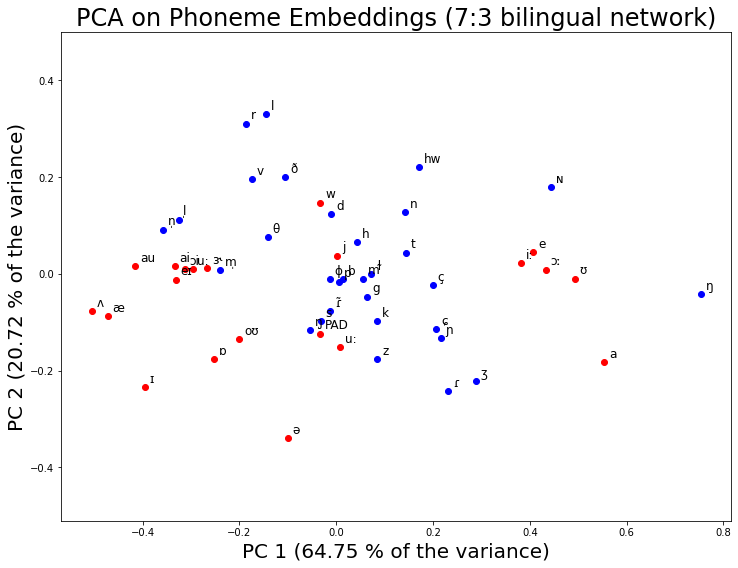

In [ ]:
pca = PCA()

pca.fit(emb_layer)

print("Explained variance by PC1 (x-axis): ", pca.explained_variance_ratio_[0])
print("Explained variance by PC2 (y-axis): ", pca.explained_variance_ratio_[1])


trans_vects = pca.transform(emb_layer)

char_labels = [phon2ipa(id2char[i]) for i in range(len(id2char))]

plt.figure(figsize=(12, 9))

for c, x, y in zip(char_labels, trans_vects[:,0], trans_vects[:,1]):

  color = "blue"
  if c == "END":
    continue
  if c in ['i:', 'e', 'w', 'j', 'a',  'ɪ', 'eɪ', 'æ', 
           'ɒ',  'u:',  'ə',  'ʌ', 'u:', 'ʊ', 'ɔː', 'ai',  'ɔi',  'au',  'oʊ',  
           'ɪ',  'ɝ', 'PAD']:
    color = "red"

  # print(c, x, y)
  plt.scatter(x, y, color=color)
  plt.text(x+0.01, y+0.01, c, fontsize=12)

plt.title("PCA on Phoneme Embeddings (7:3 bilingual network)", fontsize=24)

plt.xlabel("PC 1 ({:.2f} % of the variance)".format(pca.explained_variance_ratio_[0] * 100), fontsize=20)
plt.ylabel("PC 2 ({:.2f} % of the variance)".format(pca.explained_variance_ratio_[1] * 100), fontsize=20)
plt.axis('equal')
plt.show()

## 14. Read and creating nonsense words



In [ ]:
gem_file = folder + 'nonsense_geminates.csv'
nas_file = folder + 'nonsense_nasals.csv'

nasal_words = []
with open(nas_file) as f:
  next(f)
  nasal_words = f.readlines()
  nasal_words = [word[:-1] for word in nasal_words]

print(nasal_words[:10])

nasal_grid = np.zeros((len(nasal_words), max_len)) #

for word_i in range(len(nasal_words)):
  curr_word = nasal_words[word_i]
  for char_i in range(len(curr_word)):
    curr_char = curr_word[char_i]
    nasal_grid[word_i, char_i] = char2id[curr_char]
  
  nasal_grid[word_i, len(curr_word)] = char2id["END"]

#
# Geminates
#

gem_words = []
#with open(gem_file) as f:
#  next(f)
#  gem_words = f.readlines()
#  gem_words = [word[1:-2] for word in gem_words]
#               
#print(gem_words[:10])

for v2 in "aeiou":
  for c2 in "pbfvtdszSZckgh":
    for v1 in "aeiou":
      for c1 in "pbfvtdszSZckgh":
        gem_words.append(c1 + v1 + c2 + v2)

for v2 in "aeiou":
  for c2 in "pbfvtdszSZckgh":
    for v1 in "aeiou":
      for c1 in "pbfvtdszSZckgh":
        gem_words.append(c1 + v1 + c2 + c2 + v2)

for v3 in "aeiou":
  for c3 in "pbfvtdszSZckgh":
    for v2 in "aeiou":
      for c2 in "pbfvtdszSZckgh":
        for v1 in "aeiou":
          for c1 in "pbfvtdszSZckgh":
            gem_words.append(c1 + v1 + c2 + v2 + c3 + v3)

for v3 in "aeiou":
  for c3 in "pbfvtdszSZckgh":
    for v2 in "aeiou":
      for c2 in "pbfvtdszSZckgh":
        for v1 in "aeiou":
          for c1 in "pbfvtdszSZckgh":
            gem_words.append(c1 + v1 + c2 + v2 + c3 + c3 + v3)

gem_grid = np.zeros((len(gem_words), max_len))

for word_i in range(len(gem_words)):
  curr_word = gem_words[word_i]
  for char_i in range(len(curr_word)):
    curr_char = curr_word[char_i]
    gem_grid[word_i, char_i] = char2id[curr_char]
  
  gem_grid[word_i, len(curr_word)] = char2id["END"]

print(nasal_grid.shape)
print(gem_grid.shape)

['panma', 'banma', 'fanma', 'vanma', 'nanma', 'tanma', 'danma', 'sanma', 'zanma', 'ranma']
(61049, 24)
(695800, 24)


# 15. Calculating and plotting cross entropy for nasals



In [ ]:
def pred_words(x_in, mod, verbose=False): #thing that ir runs the words through tne network and return loss.
#cross entropy function, predict gets the y 

  y = mod.predict(x_in)

  #print(y)

  temp_y = np.append(x_in[:,1:], char2id["PAD"])

  target = np.zeros(y.shape)

  for i in range(target.shape[0]): #how different is the prediction from the output. it gets the true output 
  #and generates the one hot vactor of charcater 
    #x are the character umbers. changing the charcters into teh enxt. 
    temp_y = np.append(x_in[i,1:], char2id["PAD"])
    target[i, :,  :] = to_categorical(temp_y, num_classes = y.shape[2]) #to categorical makes the one hot vectod

  loss, acc = mod.evaluate(x_in, target, verbose=0)

  if verbose:
    print('loss', loss)

  return loss

In [ ]:
def nasal_indices(words, nasal_c, env_c): #which nonsese words have labial before n. returns the indices that have, 
 
  envs = [nasal_c + cons for cons in env_c]

  is_context = [(word[2:4] in envs) for word in words] #make sure its true nonsenewordsx

  return np.where(is_context)[0]

len(nasal_indices(nasal_words, "n", "pbfv"))
#the loss should be high 

2200

In [ ]:
import numpy as np

nps = nasal_grid[nasal_indices(nasal_words, "n", "pbfv")]
#how you select the nasal words from the grid (matrix of characters)

In [ ]:
nasal_ents = []

for nasal in "mnGM":
  for environment in ["pb", "tdsz", "y", "kg"]:
    selected_indices = nasal_indices(nasal_words, nasal, environment)

    selected_ids = nasal_grid[selected_indices]

    print(selected_ids.shape) #how many of the nasal words have that property. the nasal indices will do the vocab
    #check. 

    print(nasal, environment, selected_ids.shape)

    ent = pred_words(selected_ids, model1)
    print(ent)
    nasal_ents.append(ent)
  print()


(1100, 24)
m pb (1100, 24)
0.5921181314641779
(2200, 24)
m tdsz (2200, 24)
0.5850038055940108
(550, 24)
m y (550, 24)
0.5861856610124762
(1100, 24)
m kg (1100, 24)
0.6745884076031772

(1100, 24)
n pb (1100, 24)
0.5693093093958768
(2200, 24)
n tdsz (2200, 24)
0.4989191938530315
(550, 24)
n y (550, 24)
0.6023495457389137
(1100, 24)
n kg (1100, 24)
0.6188717512650923

(1100, 24)
G pb (1100, 24)
0.6383714790777727
(2200, 24)
G tdsz (2200, 24)
0.5957757993177935
(550, 24)
G y (550, 24)
0.6670976940068332
(1100, 24)
G kg (1100, 24)
0.47974531325426967

(1100, 24)
M pb (1100, 24)
0.7490183318745006
(2200, 24)
M tdsz (2200, 24)
0.7414124820449135
(550, 24)
M y (550, 24)
0.6805959445779974
(1100, 24)
M kg (1100, 24)
0.7645006713000211



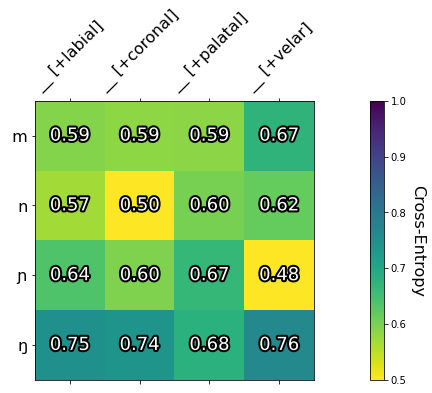

In [ ]:
import matplotlib.patheffects as pe

matfig = plt.figure(figsize=(20,5))

nasal_np = np.reshape(nasal_ents, (4,4))

im = plt.matshow(nasal_np, cmap="viridis_r", label="Cross Entropy", fignum=matfig.number, vmin=0.5, vmax=1)
# good colors - winter_r , viridis_r

ax = plt.gca()

for i in range(nasal_np.shape[0]):
    for j in range(nasal_np.shape[1]):
        text = ax.text(j, i, "{:.2f}".format(nasal_np[i, j]),
                       ha="center", va="center", color="w", fontsize=18)
        text.set_path_effects([pe.withStroke(linewidth=4, foreground='k')])

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Cross-Entropy", rotation=-90, va="bottom", fontsize=16)

#plt.imshow(-np.reshape(means, (5,4)))

plt.xticks([0, 1, 2, 3], ["__ [+labial]", "__ [+coronal]", "__ [+palatal]", "__ [+velar]"], fontsize=16, rotation=45)
plt.yticks([0, 1, 2, 3], [" m", " n", " " + phon2ipa("M"), phon2ipa("G")], fontsize=16, rotation=0)

plt.show()

In [ ]:
japanese_word_set = set(word_set) #list of all real words 

thecount = 0 #going through each of the nasal words and checcking if it is a word or not 
for word in nasal_words: 
  if word in japanese_word_set:
    thecount += 1
    #print(word, end=" ")

print(thecount) #how many words you are removing
print(len(japanese_word_set))
print(len(nasal_words)) 


def gem_indices(words, c1, c2, c3=None):
  envs = [re.split("[aeiou]", word)[:-1] for word in words]

  not_is_japanese = [word not in japanese_word_set for word in words]

  if c3 is None:
    is_context = [len(chars) == 2 and chars[0] in c1 and chars[1] in c2 for chars in envs]
  else:
    is_context = [len(chars) == 3 and chars[0] in c1 and chars[1] in c2 and chars[2] in c3 for chars in envs]

  return np.where(np.logical_and(is_context, not_is_japanese))[0]

306
44319
61049


#16. Calculating and plotting corss entropy for geminates

In [ ]:
np.array(gem_words)[(gem_indices(gem_words, ["s"], ["r"]))]
not_is_japanese = [word not in japanese_word_set for word in gem_words]
len(np.where(not_is_japanese)[0])

695039

In [ ]:
voiced_c = list("bvdzZg")
voiceless_c = list("pftsSckh")

voiced_sing = ["b", "d", "g"]
voiceless_sing = ["p", "t", "k"]

voiced_gems = ["bb", "dd", "gg"]
voiceless_gems = ["pp", "tt", "kk"]

gem_ents = []

# voiced vs voiceless geminates: 1 mora
for c1 in [voiced_c, voiceless_c]:
  for g2 in [voiced_gems, voiceless_gems]:
    print(c1, g2)
    curr_inds = gem_indices(gem_words, c1, g2)

    selected_ids = gem_grid[curr_inds]

    print(selected_ids.shape)

    ent = pred_words(selected_ids, model1)
    print(ent)
    gem_ents.append(ent)

sing_ents = []

# voiced vs voiceless singletons: 1 mora
for c1 in [voiced_c, voiceless_c]:
  for g2 in [voiced_sing, voiceless_sing]:
    print(c1, g2)
    curr_inds = gem_indices(gem_words, c1, g2)

    selected_ids = gem_grid[curr_inds]

    print(selected_ids.shape)

    ent = pred_words(selected_ids, model1)
    print(ent)
    sing_ents.append(ent)



['b', 'v', 'd', 'z', 'Z', 'g'] ['bb', 'dd', 'gg']
(446, 24)
0.6617856595013708
['b', 'v', 'd', 'z', 'Z', 'g'] ['pp', 'tt', 'kk']
(433, 24)
0.5475682612104174
['p', 'f', 't', 's', 'S', 'c', 'k', 'h'] ['bb', 'dd', 'gg']
(597, 24)
0.6514589422112533
['p', 'f', 't', 's', 'S', 'c', 'k', 'h'] ['pp', 'tt', 'kk']
(549, 24)
0.5308499424726802
['b', 'v', 'd', 'z', 'Z', 'g'] ['b', 'd', 'g']
(428, 24)
0.4495162944370341
['b', 'v', 'd', 'z', 'Z', 'g'] ['p', 't', 'k']
(417, 24)
0.4355001378831246
['p', 'f', 't', 's', 'S', 'c', 'k', 'h'] ['b', 'd', 'g']
(534, 24)
0.43764903773082775
['p', 'f', 't', 's', 'S', 'c', 'k', 'h'] ['p', 't', 'k']
(537, 24)
0.4259389887530932


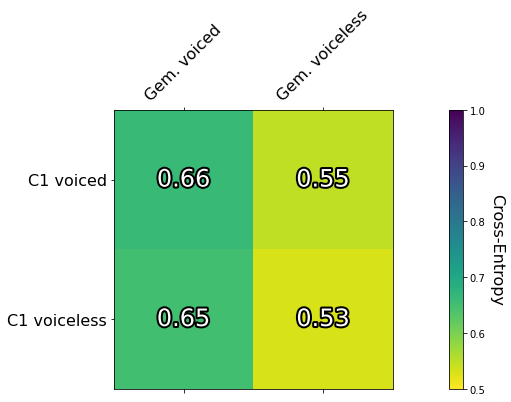

In [ ]:

import matplotlib.patheffects as pe

matfig = plt.figure(figsize=(20,5))

gem_np = np.reshape(gem_ents, (2,2))

im = plt.matshow(gem_np, cmap="viridis_r", label="Cross Entropy", fignum=matfig.number, vmin=0.5, vmax=1)
# good colors - winter_r , viridis_r

ax = plt.gca()

for i in range(gem_np.shape[0]):
    for j in range(gem_np.shape[1]):
        text = ax.text(j, i, "{:.2f}".format(gem_np[i, j]),
                       ha="center", va="center", color="w", fontsize=24)
        text.set_path_effects([pe.withStroke(linewidth=4, foreground='k')])




cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Cross-Entropy", rotation=-90, va="bottom", fontsize=16)

#plt.imshow(-np.reshape(means, (5,4)))

plt.yticks([0, 1], ["C1 voiced", "C1 voiceless"], fontsize=16)
plt.xticks([0, 1], ["Gem. voiced", "Gem. voiceless"], fontsize=16, rotation=45)

plt.show()





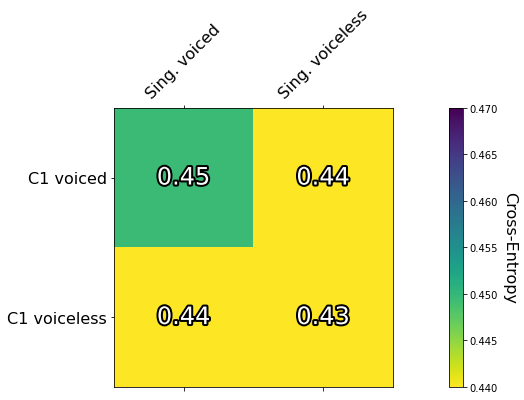

In [ ]:
matfig = plt.figure(figsize=(20,5))

sing_np = np.reshape(sing_ents, (2,2))

im = plt.matshow(sing_np, cmap="viridis_r", label="Cross Entropy", fignum=matfig.number, vmin=0.44, vmax=0.47)
# good colors - winter_r , viridis_r

ax = plt.gca()

for i in range(sing_np.shape[0]):
    for j in range(sing_np.shape[1]):
        text = ax.text(j, i, "{:.2f}".format(sing_np[i, j]),
                       ha="center", va="center", color="w", fontsize=24)
        text.set_path_effects([pe.withStroke(linewidth=4, foreground='k')])

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Cross-Entropy", rotation=-90, va="bottom", fontsize=16)

#plt.imshow(-np.reshape(means, (5,4)))

plt.yticks([0, 1], ["C1 voiced", "C1 voiceless"], fontsize=16)
plt.xticks([0, 1], ["Sing. voiced", "Sing. voiceless"], fontsize=16, rotation=45)

plt.show()